In [0]:
import os
import re
import datetime
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def prepae_data():
    x, t = [], []

    categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

    for dir_path in categorized_dir_paths:
        category_id = os.path.basename(dir_path)
        image_paths = glob(os.path.join(dir_path, '*'))
        print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

        for i, p in enumerate(image_paths):
            book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

            if i % 30 == 0:
                print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

            try:
                img = Image.open(p)
                img_resize = img.resize((229, 229))
                img_np = np.array(img_resize) / 255.0
                img_reshape = img_np.reshape(1, 229, 229, 3)
                #print(datetime.datetime.now().isoformat(), img_np.shape, img_reshape.shape)

                x.append(img_np)
                t.append(category_id)

            except Exception as e:
                print(datetime.datetime.now().isoformat(), 'Error:', e)

    return x, t

In [3]:
x, t = prepae_data()

2020-06-04T10:49:09.823801 Category 0 : 117
2020-06-04T10:49:09.824669 Image: 0 1015 0
2020-06-04T10:49:29.119065 Image: 30 1228 0
2020-06-04T10:49:48.157162 Image: 60 1106 0
2020-06-04T10:50:07.354595 Image: 90 1129 0
2020-06-04T10:50:25.121162 Category 1 : 119
2020-06-04T10:50:25.122169 Image: 0 3636 1
2020-06-04T10:50:45.656206 Image: 30 3722 1
2020-06-04T10:51:04.875814 Image: 60 3832 1
2020-06-04T10:51:24.007436 Image: 90 3777 1
2020-06-04T10:51:42.342429 Category 2 : 129
2020-06-04T10:51:42.343890 Image: 0 3601 2
2020-06-04T10:52:02.767857 Image: 30 3884 2
2020-06-04T10:52:22.374688 Image: 60 3778 2
2020-06-04T10:52:41.292972 Image: 90 3853 2
2020-06-04T10:53:00.846711 Image: 120 1502 2
2020-06-04T10:53:06.779425 Category 3 : 111
2020-06-04T10:53:06.780403 Image: 0 3312 3
2020-06-04T10:53:28.086448 Image: 30 2350 3
2020-06-04T10:53:50.225487 Image: 60 3010 3
2020-06-04T10:54:10.894066 Image: 90 3105 3


In [4]:
x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

(476, 229, 229, 3) (476,)


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [7]:
print(x_train.shape, x_val.shape)

(333, 229, 229, 3) (143, 229, 229, 3)


In [0]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [0]:
reset_seed(0)

In [10]:
category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

[0. 1. 2. 3.]
4


In [0]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=180,     # randomly rotate images in the range
    zoom_range=0.1,         # randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1, # randomly shift images vertically
    horizontal_flip=True,   # randomly flip images horizontally
    vertical_flip=True      # randomly flip images vertically
)

datagen.fit(x_train)

In [49]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:110]:
    layer.trainable = False


model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
#model.add(layers.Dense(50, activation='relu'))
#model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(category_count, activation='softmax'))

#optimizer = keras.optimizers.Adagrad(lr=0.001)
#optimizer = keras.optimizers.Adam(lr=0.001)
optimizer = keras.optimizers.SGD(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 100352)            401408    
_________________________________________________________________
dense_12 (Dense)             (None, 4096)              411045888 
_________________________________________________________________
dropout_4 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 16388     
Total params: 432,325,164
Trainable params: 419,127,348
Non-trainable params: 13,197,816
_______________________________

In [52]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit_generator(
    datagen.flow(x_train, t_train, batch_size=32),
    epochs=100,
    verbose=2,
    validation_data=(x_val, t_val),
    #steps_per_epoch=x_train.shape[0]
)

print(datetime.datetime.now().isoformat(), 'End')

2020-06-04T14:14:53.466569 Start
Epoch 1/100
11/11 - 7s - loss: 0.1936 - accuracy: 0.9429 - val_loss: 2.3774 - val_accuracy: 0.4825
Epoch 2/100
11/11 - 7s - loss: 0.1440 - accuracy: 0.9580 - val_loss: 2.3796 - val_accuracy: 0.4825
Epoch 3/100
11/11 - 7s - loss: 0.1693 - accuracy: 0.9369 - val_loss: 2.2994 - val_accuracy: 0.4755
Epoch 4/100
11/11 - 7s - loss: 0.1922 - accuracy: 0.9399 - val_loss: 2.3114 - val_accuracy: 0.4545
Epoch 5/100
11/11 - 7s - loss: 0.1676 - accuracy: 0.9369 - val_loss: 2.3468 - val_accuracy: 0.4825
Epoch 6/100
11/11 - 7s - loss: 0.1099 - accuracy: 0.9670 - val_loss: 2.3171 - val_accuracy: 0.4615
Epoch 7/100
11/11 - 7s - loss: 0.1668 - accuracy: 0.9399 - val_loss: 2.3657 - val_accuracy: 0.4476
Epoch 8/100
11/11 - 7s - loss: 0.1842 - accuracy: 0.9309 - val_loss: 2.4106 - val_accuracy: 0.4406
Epoch 9/100
11/11 - 7s - loss: 0.1163 - accuracy: 0.9550 - val_loss: 2.3179 - val_accuracy: 0.4545
Epoch 10/100
11/11 - 7s - loss: 0.1330 - accuracy: 0.9580 - val_loss: 2.4261

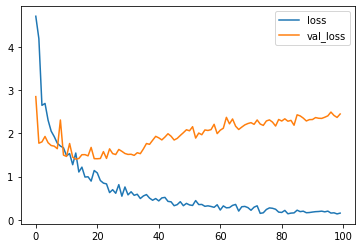

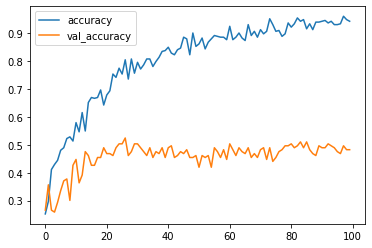

In [51]:
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

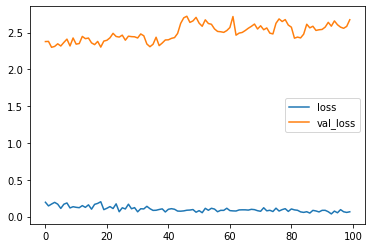

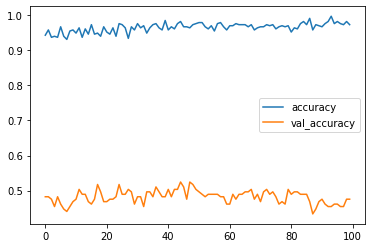

In [53]:
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()